# Neural networks

### Libraries


In [1]:
from imblearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import keras
import os
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from imblearn.pipeline import make_pipeline 
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.combine import SMOTEENN

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline 


import time
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import shap
from sklearn.preprocessing import MinMaxScaler


C:\Installed_programs\Conda\envs\dc2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [2]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test, batch_size=64, verbose=1)
    y_pred_bool = from_probs_to_class(y_pred, threshold=0.5)
    print(classification_report(y_test, y_pred_bool))
    print("fscore on test set: ", f1_score(y_test, y_pred_bool, zero_division=True))
    print("confusion matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred_bool)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

### Importing data

In [3]:
# Read the two datasets from the pickle files
dir_path = os.getcwd()

X_tr = pd.read_pickle(dir_path + "\\data\\X_train_log.pkl")
X_te = pd.read_pickle(dir_path + "\\data\\X_test_log.pkl")


y_train = pd.read_pickle(dir_path + "\\data\\y_train.pkl")
y_test = pd.read_pickle(dir_path + "\\data\\y_test.pkl")

### Normalizing the data

In [4]:
columns = X_tr.columns

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_tr), columns= columns)
X_test = pd.DataFrame (scaler.transform(X_te), columns= columns)


#### inizializations


In [5]:
model_names = []
model_instances = []
model_scores = []

In [6]:
n_iter = 80
epochs = 7
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## GridsearchCV with RandomUndersampling a NN (one hidden layer)


In [7]:
# nn base function
def create_nn_model(n_neurons_1=40, learning_rate=0.001):
    model = keras.models.Sequential([
    keras.layers.Dense(n_neurons_1,activation="relu"),
    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model


In [8]:


model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)

# Parameters
n_neurons = [4, 8, 16, 32, 64, 124, 248, 372, 496, 744, 992, 1488, 1984]

# Pipeline
smote_pipe_nn = Pipeline([("under", RandomUnderSampler()), ("model", model)])

# GridsearchCV
param_grid = dict(model__n_neurons_1=n_neurons)
grid = RandomizedSearchCV(smote_pipe_nn, param_distributions=param_grid, cv = cv,  n_iter=n_iter, n_jobs=-1, verbose=1, scoring='f1')

start = time.time()
grid_result_nn_0 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_nn_0.best_params_)
print("f1 score:", grid_result_nn_0.best_score_)


model_names.append("nn_ru_simple")
model_instances.append(grid_result_nn_0.best_estimator_)
model_scores.append(grid_result_nn_0.best_score_)

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
The total space of parameters 13 is smaller than n_iter=80. Running 13 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 13 candidates, totalling 65 fits
Process time: 80.79873776435852
Best parameters: {'model__n_neurons_1': 248}
f1 score: 0.5224065929967003


## GridsearchCV with RandomUndersampling a NN

In [9]:
# nn base function
def create_nn_model(n_neurons_1=40, n_neurons_2=20, dropout=0.1, learning_rate=0.001):
    model = keras.models.Sequential([
    keras.layers.Dense(n_neurons_1,activation="relu"),
    keras.layers.Dense(n_neurons_2,activation="relu"),
    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model


In [10]:
model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameters
n_neurons = [2, 4, 8, 16, 32, 64, 124, 248, 372, 496, 744, 992, 1488]


# Pipeline
smote_pipe_nn = Pipeline([("under", RandomUnderSampler()), ("model", model)])

# GridsearchCV
param_grid = dict(model__n_neurons_1=n_neurons, model__n_neurons_2=n_neurons)
grid = RandomizedSearchCV(smote_pipe_nn, param_distributions=param_grid, cv = cv,  n_iter=n_iter, n_jobs=-1, verbose=1, scoring='f1')

start = time.time()
grid_result_nn_1 = grid.fit(X_train, y_train)

end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_nn_1.best_params_)
print("f1 score:", grid_result_nn_1.best_score_)


model_names.append("nn_ru")                                                                                                                                                                                                                                                      
model_instances.append(grid_result_nn_1.best_estimator_)
model_scores.append(grid_result_nn_1.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Process time: 1527.2010869979858
Best parameters: {'model__n_neurons_2': 16, 'model__n_neurons_1': 1488}
f1 score: 0.5304823904611069


## GridsearchCV with class weights on a NN

In [11]:
value_counts = y_train.value_counts()
tot = len(y_train)
min_prop = round(value_counts[1]/tot, 3)
print("The proportion of the minority class on the train_set is", min_prop)

The proportion of the minority class on the train_set is 0.223


In [12]:
class_weight = {0: min_prop, 1: 1-min_prop}
model = KerasClassifier(build_fn=create_nn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0, class_weight=class_weight)

# GridsearchCV
param_grid = dict(n_neurons_1=n_neurons, n_neurons_2=n_neurons)
grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv = cv, n_jobs=-1, verbose=1, scoring='f1')

start = time.time()
grid_result_nn_2 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_nn_2.best_params_)
print("f1 score:", grid_result_nn_2.best_score_)

model_names.append("nn_classweights")
model_instances.append(grid_result_nn_2.best_estimator_)
model_scores.append(grid_result_nn_2.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Process time: 4392.907832622528
Best parameters: {'n_neurons_2': 496, 'n_neurons_1': 124}
f1 score: 0.5410550901186175


## Gridsearchcv with RandomUndersampling and CNN

In [13]:
def create_cnn_model(n_filters_1=20, n_filters_2=20, n_kernels_1=10, n_kernels_2=2, dropout=0.01):
    model = keras.models.Sequential([
    keras.layers.Conv1D(n_filters_1, n_kernels_1, activation='relu', input_shape=(None, 1)),
    keras.layers.Conv1D(n_filters_2, n_kernels_2, activation='relu'),
    keras.layers.GlobalAveragePooling1D( name="MaxPooling1D"),
    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model



In [14]:
model = KerasClassifier(build_fn=create_cnn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0)

# Parameters
n_filters = [2, 4, 8, 16, 32, 64, 128]
n_kernels = [2, 4, 8, 16]
# learning_rates = [0.1, 0.01, 0.001]

# Pipeline
smote_pipe_cnn = Pipeline([("under", RandomUnderSampler()), ("model", model)])

# GridsearchCV
param_grid = dict(model__n_filters_1=n_filters, model__n_filters_2=n_filters, model__n_kernels_1=n_kernels, model__n_kernels_2=n_kernels)
grid = RandomizedSearchCV(smote_pipe_cnn, cv = cv, param_distributions=param_grid, n_iter=n_iter, n_jobs=5, verbose=1, scoring='f1')
start = time.time()
grid_result_cnn_1 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_cnn_1.best_params_)
print("f1 score:", grid_result_cnn_1.best_score_)

model_names.append("cnn_randomunder")
model_instances.append(grid_result_cnn_1.best_estimator_)
model_scores.append(grid_result_cnn_1.best_score_)

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Process time: 990.8588535785675
Best parameters: {'model__n_kernels_2': 8, 'model__n_kernels_1': 16, 'model__n_filters_2': 32, 'model__n_filters_1': 16}
f1 score: 0.5305395883755702


## Gridsearchcv with class weights and cnn

In [15]:
def create_cnn_model(n_filters_1=20, n_filters_2=20, n_kernels_1=10, n_kernels_2=2, dropout=0.01):
    model = keras.models.Sequential([
    keras.layers.Conv1D(n_filters_1, n_kernels_1, activation='relu', input_shape=(None, 1)),
    keras.layers.Conv1D(n_filters_2, n_kernels_2, activation='relu'),
    keras.layers.GlobalAveragePooling1D( name="MaxPooling1D"),
    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model



In [16]:
class_weight = {0: min_prop, 1: 1-min_prop}

model = KerasClassifier(build_fn=create_cnn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0, class_weight=class_weight)

# Parameters
n_filters = [2, 4, 8, 16, 32, 64, 128]
n_kernels = [2, 4, 8, 16]



# GridsearchCV
param_grid = dict(n_filters_1=n_filters, n_filters_2=n_filters, n_kernels_1=n_kernels, n_kernels_2=n_kernels)
grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv = cv, n_jobs=5, verbose=1, scoring='f1')
start = time.time()
grid_result_cnn_2 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_cnn_2.best_params_)
print("f1 score:", grid_result_cnn_2.best_score_)

model_names.append("cnn_classweights")
model_instances.append(grid_result_cnn_2.best_estimator_)
model_scores.append(grid_result_cnn_2.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Process time: 1732.3997039794922
Best parameters: {'n_kernels_2': 4, 'n_kernels_1': 16, 'n_filters_2': 128, 'n_filters_1': 128}
f1 score: 0.5369457320110392


## Gridsearchcv with class weight on CNN with dense layers

In [17]:
def create_cnn_model(n_filters_1=20, n_filters_2=20, n_kernels_1=10, n_kernels_2=2, dropout=0.01, n_neurons_1=10, n_neurons_2=10):
    model = keras.models.Sequential([
    keras.layers.Conv1D(n_filters_1, n_kernels_1, activation='relu', input_shape=(None, 1)),
    keras.layers.Conv1D(n_filters_2, n_kernels_2, activation='relu'),
    keras.layers.GlobalAveragePooling1D( name="MaxPooling1D"),
    keras.layers.Dense(n_neurons_1,activation="relu"),
    keras.layers.Dense(n_neurons_2,activation="relu"),

    keras.layers.Dense(1,activation="sigmoid"),])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model


In [18]:
class_weight = {0: min_prop, 1: 1-min_prop}

model = KerasClassifier(build_fn=create_cnn_model, epochs=epochs, batch_size=10, initial_epoch=0, verbose=0, class_weight=class_weight)

# Parameters
n_filters = [2, 4, 8, 16, 32, 64, 128]
n_kernels = [2, 4, 8, 16]
n_neurons = [2, 4, 8, 16, 32, 64, 248, 496, 992]


# GridsearchCV
param_grid = dict(n_filters_1=n_filters, n_filters_2=n_filters, n_kernels_1=n_kernels, n_kernels_2=n_kernels, n_neurons_1=n_neurons,  n_neurons_2=n_neurons)
grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv = cv, n_jobs=5, verbose=1, scoring='f1')
start = time.time()
grid_result_cnn_3 = grid.fit(X_train, y_train)
end = time.time()

print("Process time:", end - start)
print("Best parameters:", grid_result_cnn_3.best_params_)
print("f1 score:", grid_result_cnn_3.best_score_)

model_names.append("cnn_classweights_with_dense")
model_instances.append(grid_result_cnn_3.best_estimator_)
model_scores.append(grid_result_cnn_3.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Process time: 3088.280990600586
Best parameters: {'n_neurons_2': 32, 'n_neurons_1': 32, 'n_kernels_2': 16, 'n_kernels_1': 16, 'n_filters_2': 4, 'n_filters_1': 2}
f1 score: 0.5285701051929831


### Printing results

In [ ]:
models_df = pd.DataFrame({"Model name": model_names, "f1 score on validation": model_scores}) 

In [20]:
models_df

,Model name,f1 score
0,nn_ru_simple,0.522407
1,nn_ru,0.530482
2,nn_classweights,0.541055
3,cnn_randomunder,0.530540
4,cnn_classweights,0.536946
5,cnn_classweights_with_dense,0.528570


In [61]:
# best model nn_class_weights
final_model = model_instances[2]

118/118 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      5873
           1       0.43      0.63      0.51      1627

    accuracy                           0.74      7500
   macro avg       0.66      0.70      0.67      7500
weighted avg       0.78      0.74      0.76      7500

fscore on test set:  0.5129624968537629
confusion matrix:


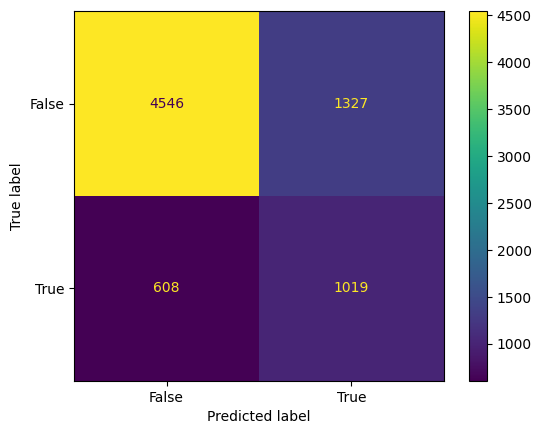

In [62]:
evaluate_model(final_model, X_test, y_test)

## SHAP

In [74]:
samples_to_analyze = 100

In [75]:
# creating dataframe with wrong prediction to analyze
preds = final_model.predict(X_test).reshape(7500)
pred_df = pd.DataFrame({"true_label": y_test, "prediction": preds})
mask = pred_df['true_label'] != pred_df['prediction']
wrong_pred_indexs = pred_df[mask].index 

235/235 [==============================] - 2s 6ms/step


In [76]:
wrong_pred_indexs

Int64Index([ 7790, 10784, 14474, 14054,  9482, 21880, 21457, 22567, 12976,
             7337,
            ...
            22470, 16227, 17739, 29341,   812, 26198,  2101, 24863, 25956,
            19705],
           dtype='int64', length=1935)

In [77]:
# creating explainer object
explainer = shap.Explainer(final_model.predict, X_test[:samples_to_analyze], verbose= False)

In [78]:
# calculating shap values
shap_values =

explainer(X_test[:samples_to_analyze])

SyntaxError: invalid syntax (792766398.py, line 2)

#### shap values for local explanation 

In [ ]:
shap.plots.bar(shap_values[0])

#### shap values for global explanation 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


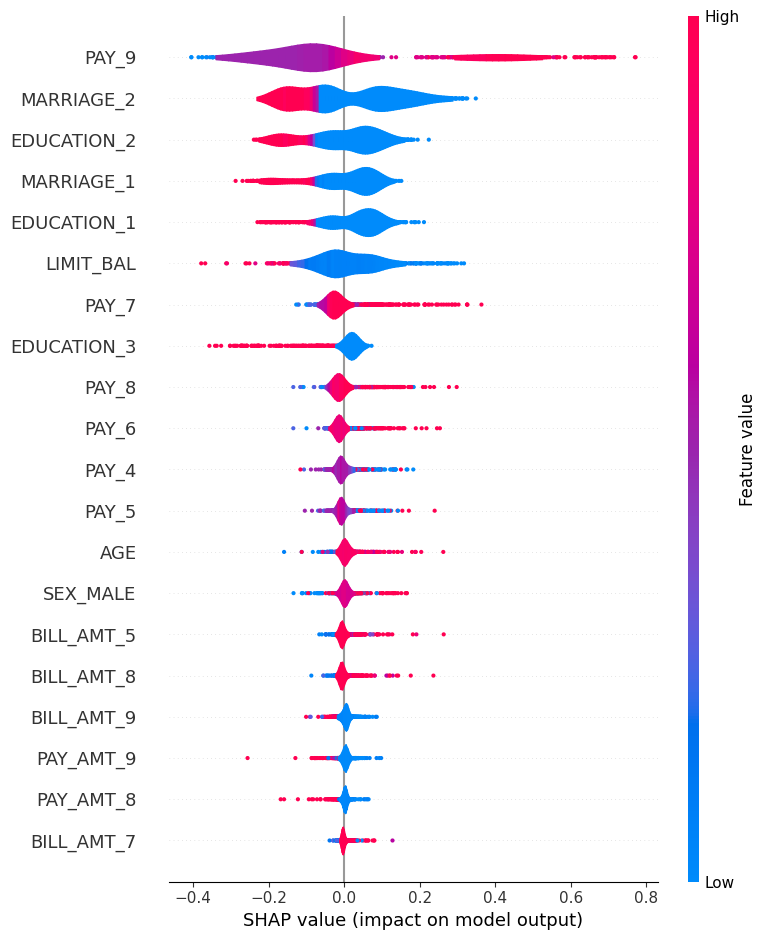

In [79]:
shap.summary_plot(shap_values, plot_type='violin')

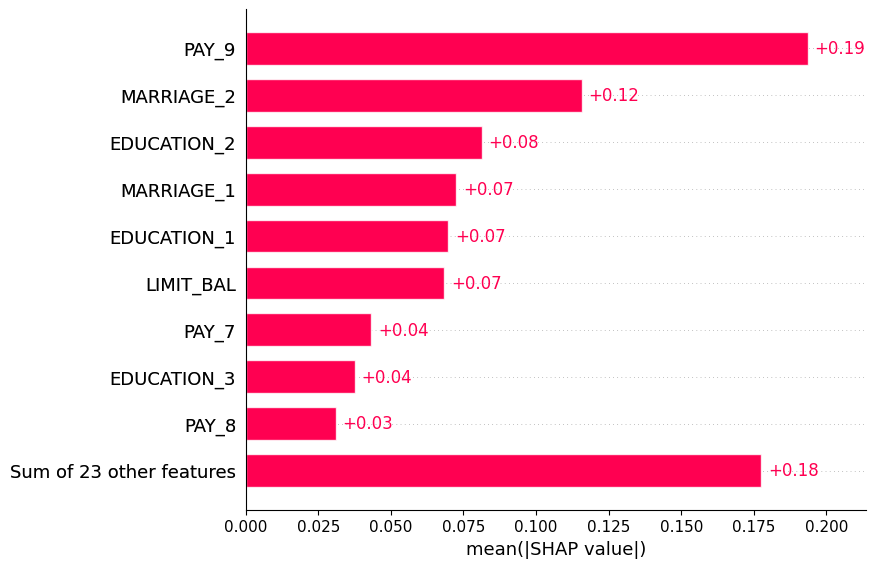

In [80]:
shap.plots.bar(shap_values)

### LIME

#### local explanation with lime

In [ ]:
# Test LIME on Isolation Forest to check why it performs that bad
from lime import lime_tabular
from lime import lime_image

# Define the tabular lime explainer
explainer = lime_tabular.LimeTabularExplainer(training_data=X_test.values,
    feature_names=X_test.columns,
    class_names=['did not default', 'default'],
    mode='classification')

# Try to explain a prediction on a sample
n_features = len(X_test.columns)
exp = explainer.explain_instance(predict_fn=final_model.predict_proba, data_row=X_test.iloc[1], num_features=n_features)

# Plot the Local explanation for class default
exp.show_in_notebook()
exp.as_pyplot_figure()
plt.tight_layout()


### Permutation feature importance

In [ ]:
# Compute Permutation Feature Importance
from sklearn.inspection import permutation_importance

r = permutation_importance(final_model, X_test.iloc[:1000], y_test.iloc[:1000], n_repeats=30, random_state=42, scoring='f1')

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

In [ ]:
fig, ax = plt.subplots()
sorted_idx = r.importances_mean.argsort()
ax.boxplot(r.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

In [ ]:
# Test LIME on SVC
svc_prob = svc_under
# Define the tabular lime explainer
explainer = LimeTabularExplainer(training_data=X_train_log.values,
    feature_names=X_train_log.columns,
    class_names=['did not default', 'default'],
    mode='classification')

# Try to explain a prediction on a sample
n_features = len(X_train_log.columns)
exp = explainer.explain_instance(predict_fn=svc_prob.predict_proba, data_row=X_test_log.iloc[1], num_features=n_features)

